In [135]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [136]:
df_train=pd.read_hdf('dftrain.h5')
df_test=pd.read_hdf('dfvalid.h5')
df_test_y=pd.read_csv('dfvalid_groundtruth.csv')
df_test_y=pd.merge(df_test_y,df_test,left_index=True,right_index=True)
df_train_ds=pd.read_csv('dt_train_ds.csv')
from sklearn.model_selection import train_test_split
df_train_ds=df_train_ds.drop('Unnamed: 0',axis=1)
feature_cols=df_train_ds.columns[1:]

X_train, X_test = train_test_split(df_train_ds[feature_cols],test_size=0.2, random_state=42)

In [137]:
df_train=pd.read_hdf('dftrain.h5')

In [138]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.281210,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,-0.054871,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,0.154837,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,0.931577,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,-0.063989,0.017228,0.015997,-0.321177,-0.503300,-0.535295,-0.562367,-0.600515,-0.573442,-0.317485,...,-0.121826,-0.134131,-0.111981,-0.057836,-0.073834,-0.125517,-0.082448,-0.036917,-0.114442,-0.183354
1673,0.993037,0.726052,0.341885,0.286314,0.535177,0.605245,0.198124,-0.375711,-0.579875,-0.495310,...,0.038658,0.188460,0.273025,0.045907,-0.108727,0.072484,0.415577,0.356382,-0.096646,-0.280273
1674,0.570550,0.253578,-0.193841,-0.502279,-0.657108,-0.838757,-0.971642,-0.881427,-0.700996,-0.520566,...,-0.146295,0.128008,0.162143,0.018287,-0.017068,0.087777,0.062175,-0.041450,-0.140199,-0.247482
1675,0.630677,0.605010,0.477897,0.155225,-0.441229,-0.679566,-0.515786,-0.424118,-0.183336,0.394784,...,0.229781,-0.041556,-0.176003,-0.301894,-0.177225,0.033001,0.025667,0.088001,0.206559,0.003667


In [139]:
df_test=pd.read_hdf('dfvalid.h5')

In [140]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,0.030987,...,0.018592,-0.017353,-0.049579,-0.061974,-0.022311,0.052058,0.091721,0.075608,0.045861,0.027268
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,0.349420,...,0.023295,-0.019617,-0.062528,-0.094405,-0.105439,-0.123830,-0.166741,-0.159385,-0.106665,-0.131186
3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,0.141141,...,-0.073682,-0.052524,-0.023897,-0.009210,0.016429,0.058000,0.097828,0.114755,0.090360,0.054764
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-18.291415,-18.288957,-18.285270,-18.282812,-18.280354,-18.276668,-18.271752,-18.268065,-18.268065,-18.270523,...,-19.514201,-19.514201,-19.515430,-19.514201,-19.511744,-19.506828,-19.501912,-19.496996,-19.493310,-19.490852
590,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,...,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138
591,0.031800,-0.143735,-0.059784,0.248039,0.283655,-0.010176,-0.153911,0.069960,0.283655,0.183167,...,0.185711,0.151367,0.166631,0.171719,0.153911,0.160271,0.141191,0.050880,-0.020352,0.025440
592,-0.026635,-0.026635,-0.006721,0.009210,-0.008464,-0.036094,-0.039082,-0.026137,-0.017674,-0.017674,...,0.104549,0.103802,0.104798,0.094841,0.073184,0.058747,0.062978,0.081399,0.103056,0.113760


In [141]:
df_test_y=pd.read_csv('dfvalid_groundtruth.csv')

In [142]:
df_test_y

,seqID,anomaly
0,0,0.0
1,1,1.0
2,2,0.0
3,3,0.0
4,4,1.0
...,...,...
589,589,1.0
590,590,1.0
591,591,0.0
592,592,0.0


In [143]:
df_test_y=pd.merge(df_test_y,df_test,left_index=True,right_index=True)
df_test_y
fcols=df_test_y.columns[2:61141]

In [144]:
s1=df_test_y[df_test_y['seqID']==1][fcols].T

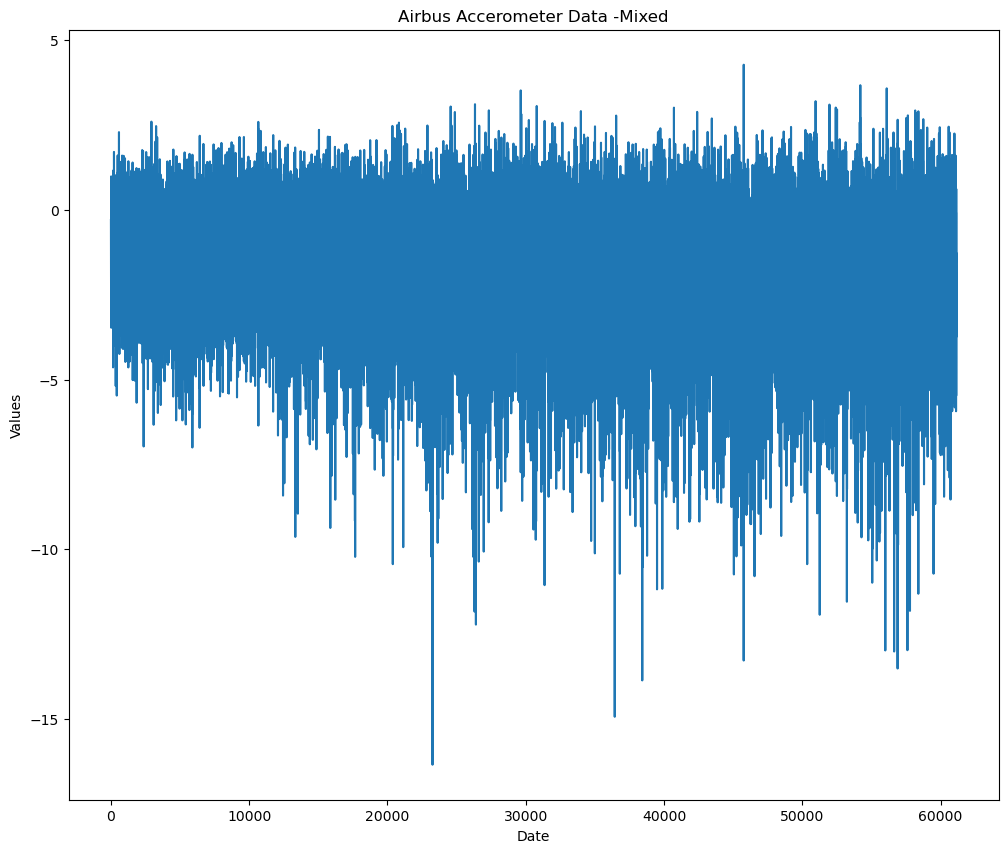

In [145]:
import matplotlib.pyplot as plt
 # Using a inbuilt style to change
# the look and feel of the plot
#plt.style.use("fivethirtyeight")

# setting figure size to 12, 10
plt.figure(figsize=(12, 10))

# Labelling the axes and setting
# a title
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Airbus Accerometer Data -Mixed")
plt.plot(np.array(s1))
#plt.plot(dataframe.rolling( window=2, min_periods=1).mean()["A"])

In [146]:
def down_sample_preprocess(df):
    dfret = pd.DataFrame()  # Initialize an empty DataFrame to store the processed data
    for i in range(0, len(df)):
        #print("Row: ", i)
        input = df[i:i + 1]  # Select a single row from the input DataFrame
        #print("Shape of input ",input.shape)
        data = input.copy()  # Create a copy of the selected row
        data = data.T  # Transpose the data (to have time series data in columns)
        data.index = pd.date_range(start='1/1/2018', periods=input.shape[1], freq='L')
        # Set the index of the transposed data as a date range starting from '1/1/2018',
        # with the number of periods equal to the length of the selected row, and with a frequency of 'L' (milliseconds)
        
        #print(data.head)
        df_t1 = data.resample('1024L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
        
        data_resample_mean = data.resample('1024L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        level_shift = (data_resample_mean - data_resample_mean.shift(-1)).interpolate()  # Perform a level shift operation on the resampled data
        df_t2 = level_shift.resample('1024L').max()  # Resample the level shifted data to a 1024L frequency and calculate the maximum
        df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
        
        df_t3 = data.resample('1024L').apply(lambda x: kurtosis(x))  # Resample the data to a 1024L frequency and apply the kurtosis function
        df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
        
        df_train_c = df_t1.join(df_t2).join(df_t3)  # Join the resampled dataframes into a single dataframe
        df_train_c['s'] = range(0, len(df_train_c))  # Add a new column 's' with values ranging from 0 to the length of the dataframe
        df_train_c['id'] = i  # Add a new column 'id' with the value of the current row index
        
        df2 = df_train_c.pivot_table(index=['id'], columns=['s'], values=['v_avg', 'v_shift', 'v_kurt'])  # Pivot the dataframe to reshape it
        df2 = df2.sort_index(axis=1, level=1)  # Sort the columns in ascending order
        
        df2.columns = [f'{x}_{y}' for x, y in df2.columns]  # Rename the columns with a combination of the original column names and the index level values
        df2 = df2.reset_index()  # Reset the index of the dataframe
        
        if (len(dfret) == 0):
            dfret = df2  # If the resulting dataframe is empty, assign it to dfret
        else:
            dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
        
    return dfret  # Return the processed dataframe

In [147]:
df_train=down_sample_preprocess(df_train)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_9092\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_9092\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_9092\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_909

In [148]:
feature_cols=df_train.columns[1:]

In [149]:
df_train=df_train[feature_cols]

In [150]:
df_test=down_sample_preprocess(df_test)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_9092\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_9092\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_9092\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_909

In [151]:
df_test = df_test.fillna(df_test.mean())[feature_cols]
df_test

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_56,v_avg_57,v_kurt_57,v_shift_57,v_avg_58,v_kurt_58,v_shift_58,v_avg_59,v_kurt_59,v_shift_59
0,0.052551,-0.013829,0.047319,0.005231,-0.265840,0.003807,0.001425,-0.211097,0.017932,-0.016508,...,0.000500,0.020830,0.103334,-0.002450,0.023280,-0.198569,-0.000735,0.024015,-0.087598,-0.000735
0,-1.547501,-0.259274,-0.028314,-1.519187,-0.571397,-0.123558,-1.395629,-0.359493,0.098209,-1.493838,...,-0.025616,-2.052561,1.548797,0.041496,-2.094057,1.736899,-0.418309,-1.675748,0.857584,-0.418309
0,-0.005793,-0.743499,0.003409,-0.009201,-0.467587,0.000254,-0.009455,-0.816908,-0.000997,-0.008458,...,-0.003528,-0.007797,-0.958179,-0.002957,-0.004839,-1.031796,0.003339,-0.008179,-1.039119,0.003339
0,0.009589,0.985710,-0.002740,0.012329,0.709863,0.021882,-0.009554,-0.320198,-0.019863,0.010310,...,0.005830,-0.002377,-0.367167,-0.000926,-0.001451,-0.008531,-0.002206,0.000755,-0.359937,-0.002206
0,-7.717476,0.009049,1.347925,-9.065401,0.131090,0.351513,-9.416914,-0.159924,-0.822680,-8.594235,...,-0.656629,-5.617131,-0.095056,0.744365,-6.361496,0.612225,-0.530261,-5.831235,-0.164034,-0.530261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-18.253942,-0.907617,0.003376,-18.257318,-0.873050,0.051236,-18.308554,-1.026898,0.101140,-18.409693,...,0.013098,-19.473189,-0.431292,0.010915,-19.484105,0.384691,0.018625,-19.502729,-0.590998,0.018625
0,-13.352138,-0.139157,0.000000,-13.352138,-0.101917,0.000000,-13.352138,-0.200859,0.000000,-13.352138,...,0.000000,-13.352138,-0.125678,0.000000,-13.352138,-0.128347,0.000000,-13.352138,-0.143680,0.000000
0,0.027820,-0.210869,-0.001724,0.029544,-0.262780,0.003150,0.026394,-0.472267,0.002887,0.023507,...,-0.010592,0.171247,-0.016263,0.007069,0.164178,0.093733,0.003527,0.160651,0.132821,0.003527
0,0.015399,-0.151603,0.018226,-0.002828,-0.350699,-0.011383,0.008555,-0.573774,0.009822,-0.001267,...,-0.012490,0.009585,-0.643038,-0.018566,0.028151,-0.989707,-0.033158,0.061309,-0.764554,-0.033158


C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


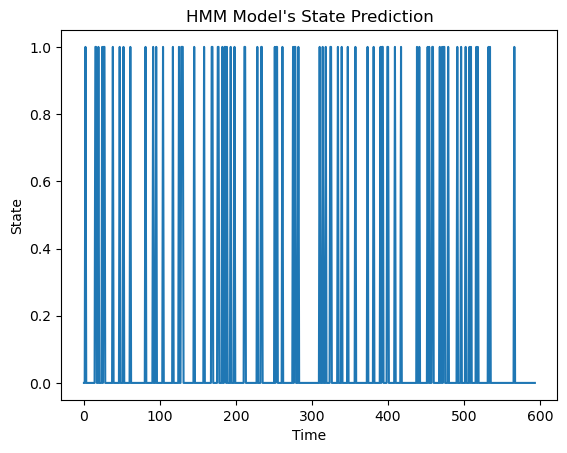

Reconstruction error: [ 0.  1. -1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1. -1.  0.  1.
  0. -1.  0.  1.  0.  0.  0.  1. -1.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0. -1.  0.  0.  0.  1.  1.  1.  0.  0. -1.  0.  1.  0.  1. -1.  1.
  1.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.
  1. -1.  0.  0.  0. -1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  1.  1. -1.  1.  0.  1.  0.  1.  1.  0.  0.
  1.  0.  0. -1. -1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  1.
  1.  1.  0.  1.  1.  1. -1.  0.  1.  1.  0.  1.  0.  1. -1. -1.  1.  1.
  0.  0. -1.  1.  1. -1. -1.  0. -1.  1.  1.  1.  1. -1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0. -1.  1.  0.  0.
  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0. -1.  1.  0.  0.  1. -1.
 -1.  0.  0.  1.  1.  1.  1. 

In [155]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
X_train = df_train
X_test = df_test

# Choose the number of hidden states
num_states = 2

# Create an HMM model
model = hmm.GaussianHMM(n_components=num_states, covariance_type="tied", random_state=42)

# Train the HMM model
model.fit(X_train)

# Generate a sequence of hidden states using the trained model
hidden_states = model.predict(X_test)

# Plot the predicted states
plt.plot(hidden_states)
plt.title("HMM Model's State Prediction")
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

# Calculate the reconstruction error as the Euclidean distance between the original and predicted observations
df_test_y = pd.read_csv('dfvalid_groundtruth.csv')
y = df_test_y['anomaly'].values
reconstruction_error = y - hidden_states
print("Reconstruction error:", reconstruction_error)

# Determine a threshold for anomaly detection
threshold = 0.5  # Adjust the threshold based on your requirements

# Apply the threshold to classify anomalies
y_hat_thresholded = np.where(reconstruction_error > threshold, 1, 0)

# Reshape y to match the shape of y_hat_thresholded
y = np.reshape(y, y_hat_thresholded.shape)

# Calculate accuracy rate
accuracy = np.sum(y == y_hat_thresholded) / len(y)
print("Accuracy rate:", accuracy)

# Calculate precision
precision = precision_score(y, y_hat_thresholded)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y, y_hat_thresholded)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y, y_hat_thresholded)
print("F1 score:", f1)
